**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

## 1. Подключение необходимых библиотек и данных
По мере необходиомсти, в самом начале будем подключать все библиотеки и прописывать глобальные пути и переменные.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
import catboost as catb
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
matplotlib.rcParams.update({'font.size': 14})
rs = 22

TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
SUBMIT_PATH = 'SergeyLazarevich_predictions.csv'

## 2. Загрузка данных в Data Frame
#### Описание файлов
- **course_project_train.csv** - тренировочные данные
- **course_project_test.csv** - тестовые данные
- **SergeyLazarevich_predictions.csv** - файл для отправки
#### Описание признаков данных
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [2]:
# Импортируем данные в pandas Dataframe
df_train = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [3]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


## Рассмотрим поближе каждую характеристику 

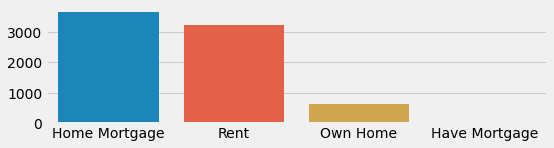


Количество пропущенных элементов 0
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Количество уникальных элементов 4


In [4]:
#Home Ownership - домовладение
index = 'Home Ownership'
counts = df_train[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(df_train[index].value_counts())
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Имеем 4 уникальных значений. Пропусков нет. В последствии переведём этот признак из категориального в бинарный при помощи pd.get_dummies().*

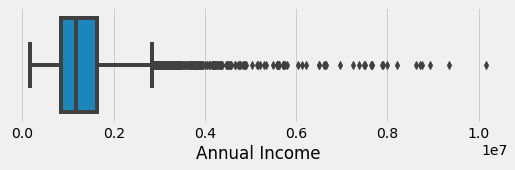


Количество пропущенных элементов 1557
median - nan
mean - 1366391.7201749957
mode - 969475.0

164597.0      1
175845.0      1
177251.0      1
191577.0      1
192223.0      1
             ..
8710740.0     1
8758449.0     1
8923844.0     1
9338880.0     1
10149344.0    1
Name: Annual Income, Length: 5478, dtype: int64

Количество уникальных элементов 5478


In [5]:
#Annual Income - годовой доход
index = 'Annual Income'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Здесь все элементы уникальны, будем их группировать. Пропуски заполним модой.*

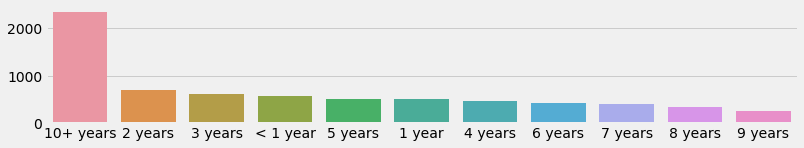


Количество пропущенных элементов 371
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Количество уникальных элементов 11


In [6]:
#Years in current job - количество лет на текущем месте работы
index = 'Years in current job'
counts = df_train[index].value_counts()
plt.figure(figsize=(12, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(df_train[index].value_counts())
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Имеем 11 уникальных значений. В последствии переведём этот признак из категориального в числовой (1 - 10). Пропуски заполним 1.*

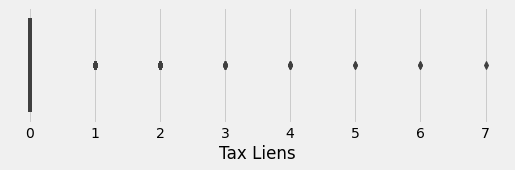


Количество пропущенных элементов 0
median - 0.0
mean - 0.030133333333333335
mode - 0.0

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

Количество уникальных элементов 8


In [7]:
#Tax Liens - налоговые обременения
index = 'Tax Liens'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Этот признак является категориальным, поэтому преобразуем его в соответствии с уникальными значениями.*

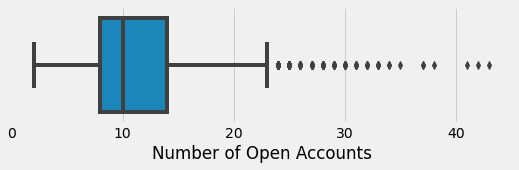


Количество пропущенных элементов 0
median - 10.0
mean - 11.130933333333333
mode - 9.0

2.0      28
3.0      95
4.0     212
5.0     325
6.0     504
7.0     613
8.0     638
9.0     728
10.0    677
11.0    692
12.0    562
13.0    465
14.0    420
15.0    313
16.0    265
17.0    232
18.0    143
19.0    139
20.0     93
21.0     78
22.0     49
23.0     59
24.0     50
25.0     32
26.0     12
27.0     14
28.0     14
29.0     10
30.0     11
31.0      6
32.0      6
33.0      6
34.0      2
35.0      1
37.0      2
38.0      1
41.0      1
42.0      1
43.0      1
Name: Number of Open Accounts, dtype: int64

Количество уникальных элементов 39


In [8]:
#Number of Open Accounts - количество открытых счетов
index = 'Number of Open Accounts'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Здесь всё хорошо так что не чего менять не будем.*

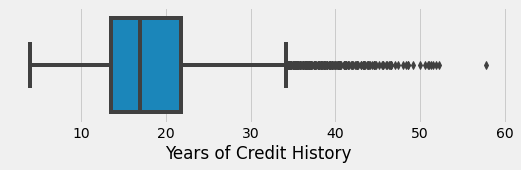


Количество пропущенных элементов 0
median - 17.0
mean - 18.317466666666668
mode - 15.0

4.0     1
4.3     1
4.5     2
4.7     2
4.8     4
       ..
51.3    1
51.5    1
51.9    1
52.2    1
57.7    1
Name: Years of Credit History, Length: 408, dtype: int64

Количество уникальных элементов 408


In [9]:
#Years of Credit History - количество лет кредитной истории
index = 'Years of Credit History'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Здесь всё хорошо. Может в последствии группирую по десяткам.*

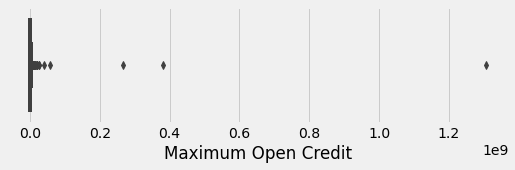


Количество пропущенных элементов 0
median - 478159.0
mean - 945153.7274666667
mode - 0.0

0.000000e+00    65
4.334000e+03     1
6.556000e+03     1
6.622000e+03     1
1.089000e+04     1
                ..
4.092389e+07     1
5.756256e+07     1
2.655129e+08     1
3.800523e+08     1
1.304726e+09     1
Name: Maximum Open Credit, Length: 6963, dtype: int64

Количество уникальных элементов 6963


In [10]:
#Maximum Open Credit - наибольший открытый кредит
index = 'Maximum Open Credit'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Здесь все элементы уникальны, будем их группировать и обрабатывать выбросы*

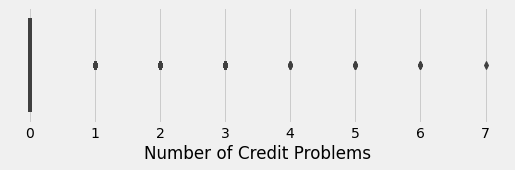


Количество пропущенных элементов 0
median - 0.0
mean - 0.17
mode - 0.0

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

Количество уникальных элементов 8


In [11]:
#Number of Credit Problems - количество проблем с кредитом
index = 'Number of Credit Problems'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Этот признак является категориальным, поэтому преобразуем его в соответствии с уникальными значениями.*

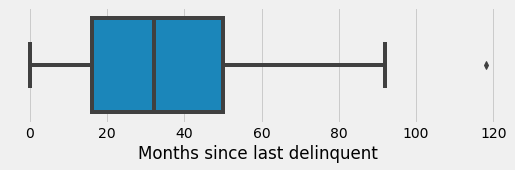


Количество пропущенных элементов 4081
median - nan
mean - 34.69260017548991
mode - 14.0

0.0      18
1.0      26
2.0      25
3.0      30
4.0      31
         ..
84.0      1
86.0      1
91.0      1
92.0      1
118.0     1
Name: Months since last delinquent, Length: 89, dtype: int64

Количество уникальных элементов 89


In [12]:
#Months since last delinquent - количество месяцев с последней просрочки платежа
index = 'Months since last delinquent'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Имеем 89 уникальных значений. В последствии сгруппируем (0 - 50). Пропуски заполним 0, так как они означают отсутствие просрочек по кредитам.*

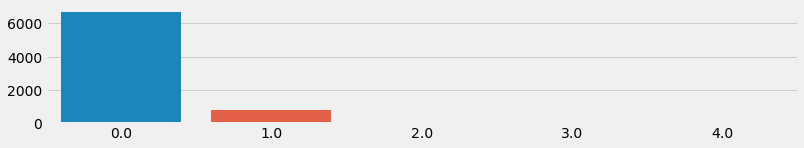


Количество пропущенных элементов 14
0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

Количество уникальных элементов 5


In [13]:
#Bankruptcies - банкротства
index = 'Bankruptcies'
counts = df_train[index].value_counts()
plt.figure(figsize=(12, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(df_train[index].value_counts())
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Этот признак является категориальным, поэтому преобразуем его в соответствии с уникальными значениями. Пропуски заполним 0, так как они означают отсутствие банкротства.*

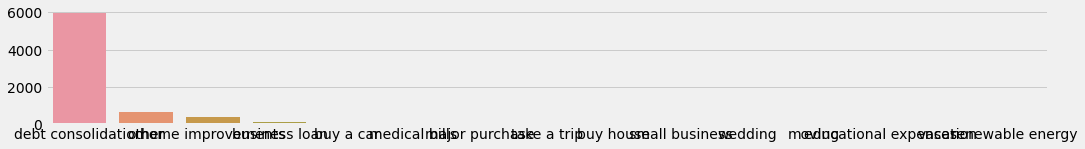


Количество пропущенных элементов 0
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

Количество уникальных элементов 15


In [14]:
#Purpose - цель кредита
index = 'Purpose'
counts = df_train[index].value_counts()
plt.figure(figsize=(16, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(df_train[index].value_counts())
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Имеем 15 уникальных значений. Пропусков нет. В последствии переведём этот признак из категориального в бинарный при помощи pd.get_dummies().*

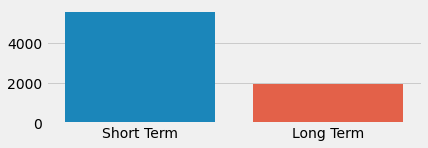


Количество пропущенных элементов 0
Short Term    5556
Long Term     1944
Name: Term, dtype: int64

Количество уникальных элементов 2


In [15]:
#Term - срок кредита
index = 'Term'
counts = df_train[index].value_counts()
plt.figure(figsize=(6, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(df_train[index].value_counts())
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Имеем 2 уникальных значений. Пропусков нет. В последствии переведём этот признак из категориального в бинарный при помощи pd.get_dummies().*

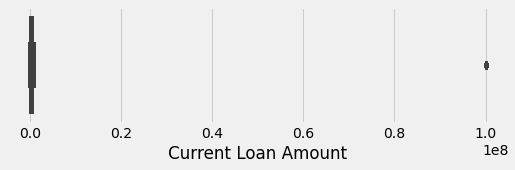


Количество пропущенных элементов 0
median - 309573.0
mean - 11873177.445066666
mode - 99999999.0

11242.0         1
21472.0         2
21516.0         1
21560.0         1
21582.0         1
             ... 
788634.0        2
788788.0        1
788942.0        1
789030.0        1
99999999.0    870
Name: Current Loan Amount, Length: 5386, dtype: int64

Количество уникальных элементов 5386


In [16]:
#Current Loan Amount - текущая сумма кредита
index = 'Current Loan Amount'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Здесь большинство элементов уникальны, будем их группировать и обрабатывать выбросы (прировняем их к медиане)*

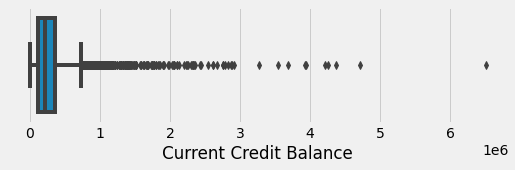


Количество пропущенных элементов 0
median - 209323.0
mean - 289833.2352
mode - 0.0

0.0          53
19.0          3
57.0          2
76.0          2
95.0          1
             ..
4209659.0     1
4249673.0     1
4367245.0     1
4720132.0     1
6506797.0     1
Name: Current Credit Balance, Length: 6592, dtype: int64

Количество уникальных элементов 6592


In [17]:
#Current Credit Balance - текущий кредитный баланс
index = 'Current Credit Balance'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Здесь большинство элементов уникальны, будем их группировать и обрабатывать выбросы*

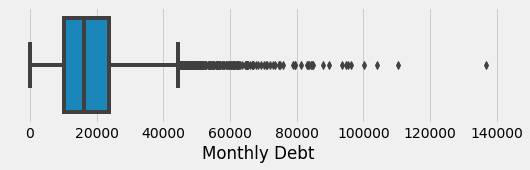


Количество пропущенных элементов 0
median - 16076.5
mean - 18314.454133333333
mode - 0.0

0.0         6
17.0        1
21.0        1
42.0        1
57.0        1
           ..
96177.0     1
100091.0    1
104036.0    1
110311.0    1
136679.0    1
Name: Monthly Debt, Length: 6716, dtype: int64

Количество уникальных элементов 6716


In [18]:
#Monthly Debt - ежемесячный долг
index = 'Monthly Debt'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Здесь большинство элементов уникальны, будем их группировать или всё так и оставим.*

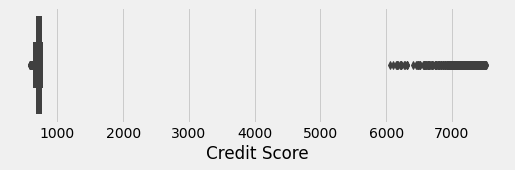


Количество пропущенных элементов 1557
median - nan
mean - 1151.0874978966851
mode - 740.0

585.0     1
586.0     1
588.0     1
589.0     1
590.0     1
         ..
7470.0    4
7480.0    6
7490.0    2
7500.0    2
7510.0    2
Name: Credit Score, Length: 268, dtype: int64

Количество уникальных элементов 268


In [19]:
#Credit Score - кредитный рейтинг
index = 'Credit Score'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Здесь большинство элементов уникальны, пропуски заполним модой, выбросы получились скорее всего при добавление лишнего ранга (0).*

## Исследование целевой переменной
### Построим график распределения целевой переменной "Credit Default" - факт невыполнения кредитных обязательств

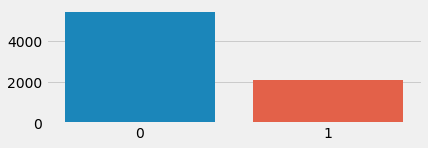


Количество пропущенных элементов 0
0    5387
1    2113
Name: Credit Default, dtype: int64

Количество уникальных элементов 2


In [20]:
#Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)
index = 'Credit Default'
counts = df_train[index].value_counts()
plt.figure(figsize=(6, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(df_train[index].value_counts())
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Вывод: имеем не большой дисбаланс классов, в последствии будем проводить балансировку методом Oversampling*

## Обработка данных

In [21]:
class DataPreprocessing():
    def __init__(self):
        self.medians = None
        self.mode =  None
        self.Purpose_list = ['debt consolidation','other','home improvements','business loan','buy a car','medical bills','major purchase','take a trip',
                        'buy house','small business','wedding','educational expenses','moving','vacation','renewable energy']
        self.value_Bankruptcies =  None
        self.value_District =  None
        self.value_Credit =  None

    def fit(self, df):
        df = df.copy()
        #заполняем переменные класса
        self.medians = df.median()
        self.mode = df.mode()
        self.value_Bankruptcies = df['Bankruptcies'].value_counts().to_dict() 
        self.value_District = df['Tax Liens'].value_counts().to_dict() 
        self.value_Credit = df['Number of Credit Problems'].value_counts().to_dict() 

    def transform(self, df):
        df = df.copy()
        # добавим колонку ID
        df['Id'] = df.index.tolist()
        df = df.set_index('Id')
        # Переведём 'Home Ownership' признак из категориального в бинарный
        df = pd.get_dummies(df, columns=['Home Ownership'], prefix='Home')
        # Исправим пропуски 'Annual Income' 
        df.loc[df['Annual Income'].isna(), 'Annual Income'] = self.medians[0]
        # Переведём признак из категориального в числовой (1 - 10). Пропуски заполним 0.
        Years_dist = {'10+ years': 10,'2 years': 2,'3 years': 3,'< 1 year': 0,'5 years': 5,'1 year': 1,'4 years': 4,'6 years': 6,'7 years': 7,'8 years': 8,'9 years': 9}
        df = df.replace({'Years in current job': Years_dist})
        df.loc[df['Years in current job'].isna(), 'Years in current job'] = 0
        df.drop(['Years in current job'], axis=1, inplace=True)
        # Преобразуем 'Tax Liens' в соответствии с уникальными значениями
        df = df.replace({'Tax Liens': self.value_District})
        # Округляем значения к целому.
        df['Years of Credit History'] = np.round_(df['Years of Credit History'], decimals = 0)
        # Преобразуем 'Number of Credit Problems' в соответствии с уникальными значениями 
        df = df.replace({'Number of Credit Problems': self.value_Credit})
        # Исправим пропуски 'Months since last delinquent' 
        df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0
        # Исправим пропуски 'Bankruptcies'. Преобразуем в соответствии с уникальными значениями 
        df.loc[df['Bankruptcies'].isna(), 'Bankruptcies'] = 0
        df = df.replace({'Bankruptcies': self.value_Bankruptcies})
        # Переведём 'Purpose' признак из категориального в бинарный
        df[self.Purpose_list] = 0
        for index in self.Purpose_list:
            df.loc[df['Purpose'] == index, index] = 1
        df.drop(['Purpose'], axis=1, inplace=True)
        # Переведём 'Term' признак из категориального в бинарный
        df = pd.get_dummies(df, columns=['Term'])
        # Обрабатываем выбросы 'Current Loan Amount' (прировняем их к медиане). 
        # 999999 означает что клиент очень надёжен и ему открыт безлимит, пометим их отдельно.
        df['Current Loan Amount Unlimited'] = 0
        df.loc[df['Current Loan Amount'] > 99999998, 'Current Loan Amount Unlimited'] = 1
        df.loc[df['Current Loan Amount'] > 99999998, 'Current Loan Amount'] = self.medians[8]
        # Исправим пропуски 'Credit Score'(прировняем их к медиане). 
        # Обрабатываем выбросы 'Credit Score' делим на 10 
        df.loc[df['Credit Score'].isna(), 'Credit Score'] = self.mode['Credit Score'][0]
        df['Credit Score Unlimited'] = 0
        condition = (df['Credit Score'] > 800)
        df.loc[condition, 'Credit Score Unlimited'] = 1
        df.loc[condition, 'Credit Score'] = df.loc[condition, 'Credit Score'] / 10
        return df

In [22]:
class FeatureGenetator():
    def __init__(self):
        #self.scaler = RobustScaler()
        self.scaler = StandardScaler()
        #self.scaler = MinMaxScaler()

    def fit(self, df):
        df = df.copy()
        

    def transform(self, df):
        df = df.copy()
        # Средний заработок в месяц
        df['Monthly Income'] = np.round_(df['Annual Income'] / 12, decimals = 0)
        # Часть платежа по кредиту от заработка 
        df['Debt/Income'] = np.round_((df['Monthly Debt'] / df['Monthly Income']) * 100, decimals = 0)
        return df

    def fit_scale_merge(self, df):
        #Масштабирование
        self.scaler.fit_transform(df)

    def scale_merge(self, df):
        df = df.copy()
        #Масштабирование
        df = pd.DataFrame(self.scaler.transform(df), columns=df.columns)
        return df

In [23]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [24]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    y_test_true = y_test_true['Credit Default'].to_numpy()
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

### Разбиение на train и test

In [25]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=['Credit Default'])
y = train_df['Credit Default']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=rs)

In [26]:
y_train.value_counts()

0    3793
1    1457
Name: Credit Default, dtype: int64

### Обработка признаков

In [27]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((5250, 35), (2250, 35), (2500, 35))

In [28]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [29]:
X_train = reduce_mem_usage(X_train)
X_valid = reduce_mem_usage(X_valid)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 1.23 MB
Memory usage after optimization is: 0.49 MB
Decreased by 60.6%
Memory usage of dataframe is 0.53 MB
Memory usage after optimization is: 0.21 MB
Decreased by 60.6%
Memory usage of dataframe is 0.59 MB
Memory usage after optimization is: 0.23 MB
Decreased by 60.6%


### Генерация новых фич

In [30]:
features_gen = FeatureGenetator()
features_gen.fit(X_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((5250, 37), (2250, 37), (2500, 37))

### Нормализация данных

In [31]:
features_gen.fit_scale_merge(X_train)

X_train = features_gen.scale_merge(X_train)
X_valid = features_gen.scale_merge(X_valid)
test_df = features_gen.scale_merge(test_df)

X_train.shape, X_valid.shape, test_df.shape

((5250, 37), (2250, 37), (2500, 37))

### Балансировка целевой переменной

In [32]:
X_train_columns = X_train.columns.to_list()
ros = RandomOverSampler(random_state=rs)
X_train, y_train = ros.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train,columns=X_train_columns)
y_train = pd.DataFrame(y_train)
print ("Train\n", y_train.value_counts())
y_valid = pd.DataFrame(y_valid)
print ("\nValid\n", y_valid.value_counts())

Train
 Credit Default
0                 3793
1                 3793
dtype: int64

Valid
 Credit Default
0                 1594
1                  656
dtype: int64


### Выбор лучшей модели и подбор гиперпараметров

In [33]:
import catboost as catb
model = catb.CatBoostClassifier(silent=True, random_state=rs,n_estimators=100, max_depth=3, l2_leaf_reg=5)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.76      0.72      3793
           1       0.73      0.64      0.68      3793

    accuracy                           0.70      7586
   macro avg       0.70      0.70      0.70      7586
weighted avg       0.70      0.70      0.70      7586

TEST

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1594
           1       0.51      0.62      0.56       656

    accuracy                           0.71      2250
   macro avg       0.67      0.69      0.67      2250
weighted avg       0.73      0.71      0.72      2250

CONFUSION MATRIX

col_0     0    1
row_0           
0      1203  391
1       251  405


### Важность признаков

In [34]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

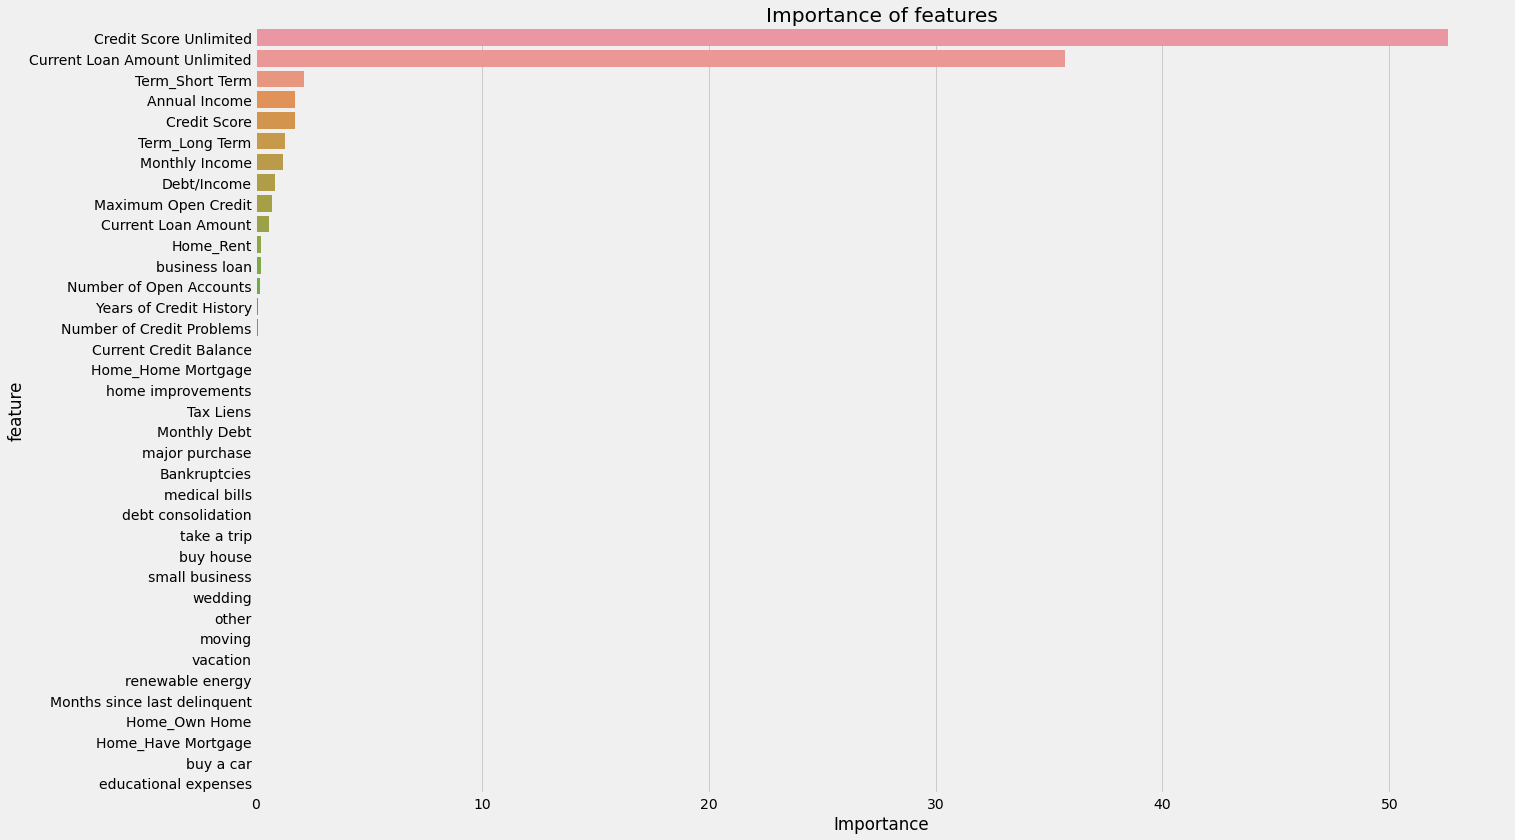

In [35]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top=20)

### Кросс-валидация на всём объёме данных

In [36]:
Xx = X_train.copy()
Xx = Xx.append(X_valid, ignore_index=False)
Yy = y_train.copy()
Yy = Yy.append(y_valid, ignore_index=False) 
Xx.shape, Yy.shape

((9836, 37), (9836, 1))

In [37]:
cv=KFold(n_splits=5, random_state=rs, shuffle=True)
cv_score = cross_val_score(model, Xx, Yy, scoring='f1_macro', cv=cv)
print(cv_score)

[0.66362749 0.67942073 0.66381594 0.6682651  0.66764571]


### Финальная модель

In [38]:
import catboost as catb
final_catb = catb.CatBoostClassifier(silent=True, random_state=rs,n_estimators=100, max_depth=3, l2_leaf_reg=5)
final_catb.fit(X_train[important_features_top], y_train)
y_train_pred = final_catb.predict(X_train[important_features_top])
y_valid_pred = final_catb.predict(X_valid[important_features_top])
get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.75      0.72      3793
           1       0.73      0.67      0.70      3793

    accuracy                           0.71      7586
   macro avg       0.71      0.71      0.71      7586
weighted avg       0.71      0.71      0.71      7586

TEST

              precision    recall  f1-score   support

           0       0.83      0.74      0.78      1594
           1       0.50      0.64      0.57       656

    accuracy                           0.71      2250
   macro avg       0.67      0.69      0.67      2250
weighted avg       0.74      0.71      0.72      2250

CONFUSION MATRIX

col_0     0    1
row_0           
0      1181  413
1       235  421


In [39]:
y_test_preds = final_catb.predict(test_df[important_features_top])

In [40]:
df = pd.DataFrame(y_test_preds)
df.columns =['Credit Default'] 
df['Id'] = df.index.tolist()
df = df.set_index('Id')
df.head()

,Credit Default
Id,
0,0
1,1
2,1
3,0
4,0


In [41]:
test_df.shape , df.shape

((2500, 37), (2500, 1))

In [42]:
df['Credit Default'].value_counts()

0    1581
1     919
Name: Credit Default, dtype: int64

In [43]:
df.to_csv('SergeyLazarevich_predictions.csv')